# OPTRAM

In [1]:
import os
import pandas as pd
import utm 
import folium
import re
from pathlib import Path
import geopandas as gpd
from shapely import geometry
from osgeo import gdal, gdalconst
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import datetime
import math
import rasterio as rs
#from scipy import stats
import sys
import glob
import haversine as hs
from haversine import Unit
from shapely.geometry import Point
import pickle
from dask.distributed import Client
import dask.dataframe as dd
import dask
import datashader as ds
import colorcet as cc
import numpy

### Functions

In [4]:
def utm_to_latlon(coords, zone_number = 12, zone_letter = 'N'):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

def S2_getDate(filename) :
    basename = Path(filename).stem  
    try :
        found = re.search('S2(A|B)2A_(\d+)_.*',basename).group(2)
        dt = datetime.datetime.strptime(found, '%Y%m%d')
        
    except AttributeError:
        raise ValueError('Error: Date can not be extracted from filename %s .' % filename)
        
    return dt

# TODO unify funcs S2_get*
def S2_getSCL(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except AttributeError: 
        print('Error: File with pattern %s not found' % pattern)
        
def S2_getNDVI(BASE_DIR, date) :
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
    
    pattern = BASE_DIR + '*' + date_str + '*'
    
    try: 
        filepath = glob.glob(pathname = pattern)
        return filepath[0]
    
    except Exception as e: 
        print('Error while reading file %s' % pattern)
        print(e)
        
def S2_get_sensing_dt(boa_fp):
    days_offset = 1
    start_dt = S2_getDate(boa_fp) - datetime.timedelta(days=days_offset)
    end_dt   = S2_getDate(boa_fp) + datetime.timedelta(days=days_offset)
    
    start_dt = start_dt.strftime('%Y-%m-%d')
    end_dt   = end_dt.strftime('%Y-%m-%d')

    now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
    print('[%s] : Requesting image metadata between %s <-> %s...' % (now, start_dt, end_dt))
    # bash callback: 
    dts = ! Rscript ./sen2r/sat_sensing_dt.R $start_dt $end_dt ./sen2r/Walnut-Gulch.geojson 2> /dev/null
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    sensing_datetime = datetime.datetime.strptime(dts[1], '                                        "%Y-%m-%d %H:%M:%S UTC" ')
    return sensing_datetime


def is_defective_px(SCL_px_val):
    
    if ((SCL_px_val == 4) | (SCL_px_val == 5)): # vegetated OR not_vegetated
        return False
    
    else : 
        return True

# Vectorized version
is_defective_px_vect = np.vectorize(is_defective_px)

# TODO: maybe in the denominator are included alpha values and thus
# computing an undervaluated percentage ?
# TODO type checks 
# TODO shape checks  
def S2_defective_px_perc(scl_raster) : 
    not_defective = sum(~np.array(is_defective_px_vect(scl_raster)))
    perc = not_defective / len(np.ndarray.flatten(scl_raster))
    return perc

def get_px_coords_from_raster(boa, no_data, band) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(band, masked = True)
    #no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))


def build_inSitu_obs(df, dest_lat_lng, sensor_df, dists, sensor_name, utm_n = 12, utm_z = 'N') :
    
    # Calculate the closest image pixel to the sensor
    x = df.loc[:,'utm_x'].tolist()
    y = df.loc[:,'utm_y'].tolist()

    df['dist'] = [float(dist) for dist in dists] # TODO 'dists' should already be a float list.
    df['sensor_name'] = sensor_name
    print('[%s] : Sorting %d rows...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), len(df)))
    df.sort_values('dist', inplace = True)
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    df = df.head(1)
    df.set_index('datetime', inplace = True) # indexing is costly, but only one 1 obs, see previous line
    
    # Get the corresponding sensor obs to the pixel
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
              
    nearest_dt = nearest(items = sensor_df.index, pivot = df.index[0])
    val = sensor_df.loc[sensor_df.index == nearest_dt, 'SM5'].values
    print('nearest_dt: %s, %s'% (nearest_dt, val))
    #df.loc[:,'SM5'] = float(val)
    df['SM5'] = float(val)
    return df


def get_haversine_dist_df(utm_coords, sensor_coords, sensor_name, utm_n = 12, utm_z = 'N') : 
   # Calculate the closest image pixel to the sensor
    #x = sensor_df.loc[:,'utm_x'].tolist()
    #y = sensor_df.loc[:,'utm_y'].tolist()

    print('[%s] : Calculating haversine distance for sensor %s...'
          % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"), sensor_name))
    
    dists = [  hs.haversine(utm_to_latlon(utm_coord, utm_n, utm_Z),
                            sensor_coords, unit = Unit.METERS)
        
               for utm_coord in utm_coords 
    ]
    
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

    return(dists)

def get_distances_pxs_to_sensor(boa_dummy, sensors_coords, utm_x, utm_y):
    #boa_fp = BASE_DIR_BOA + boa_files[0]
    #boa_dummy  = rs.open(boa_fp)
    h_dists = { sensor_name : get_haversine_dist_df(utm_coords = zip(utm_x, utm_y),
                                                    sensor_coords = sensors_coords[sensor_name],
                                                    sensor_name = sensor_name) 
                    for sensor_name, sensor_coords in sensors_coords.items()} 
    return (h_dists)

def resample_raster_gdal_nn(input_file, ref_file, out_file):
    # Opening input
    input = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    # Opening ref
    reference = gdal.Open(ref_file, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    # Resampling
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(out_file,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_NearestNeighbour)
    del output
    del input
    del reference

def add_scl_col(scl_fp, ndvi_fp, local_df, date,  scl_dir = "./sen2r/out/SCL_res10/"):
    #input_file = scl_fp
    #ref_file = ndvi_fp
    #tempfile ?
    #out_file = "./SCL_resampled_10_gdal_" + raster_date.strftime("%Y-%m-%d") + ".tif"
    
    if os.path.isdir(scl_dir):
        pass
    else:
        os.mkdir(scl_dir)
    
    if (isinstance(date, datetime.date)) : 
        date_str = date.strftime("%Y%m%d")
    
    elif (isinstance(date, str)):
        print('"str" type object detected, converting to datetime.')
        date_obj = datetime.datetime.strptime(date, "%Y%m%d") 
        date_str = date_obj.strftime("%Y%m%d")
        
    else : 
        raise TypeError('Error:  %s encountered, but "str" o "datetime.date" expected' % type(date))
        
    scl_10_fp = os.path.join(scl_dir, date_str + "_SCL_10m_resampled_by_gdal.tif")
    resample_raster_gdal_nn(input_file = scl_fp,
                            ref_file   = ndvi_fp,
                            out_file   = scl_10_fp)

    scl_10_dataset  = rs.open(scl_10_fp)
    scl_10          = scl_10_dataset.read(1, masked = True)
    scl_10_flatten  = np.ndarray.flatten(scl_10) 

    # TODO: May this be precomputed for speed-up ?
    #   - Theoretically yes, since the SCL resampled rasters should have the same dims 
    x,y = get_px_coords_from_raster(scl_10_dataset,
                                    no_data = 0,
                                    band = 1) 

    scl_10_df = pd.DataFrame({
        'utm_x' : x,
        'utm_y' : y,
        'scl_value' : np.delete(scl_10_flatten, scl_10_flatten == 0)
    })
    scl_10_df = scl_10_df.astype('int')    
    local_df = pd.merge(local_df, scl_10_df, on = ["utm_x", "utm_y"], how = "left")
    return(local_df)

In [5]:
if False: # Do not run
    
    fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
    print(S2_getDate(fname))
    
    SCL_file = S2_getSCL(BASE_DIR, date = '20181213')  
    print(SCL_file)
    

## REGION OF STUDY


In [6]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


Plotting with Folium requires lat, long data, so we have to convert from UTM

In [7]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [8]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html


sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}

sensors_coords = {s_key : utm_to_latlon(s_utm, utm_N, utm_Z) 
                  for s_key, s_utm in sensor_coords_utm.items()}

In [9]:
m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

 Shapefile to geojson conversion

In [10]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## LOAD DATA

### Sensor 

In [11]:
 %%time

sensor_path = "./sensor_data"
sensors_df = {}
    
if False: 
    # TODO : check existence of sensor_path folder
    names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
    url_base = 'https://www.tucson.ars.ag.gov/metDAP/'
    for sensor_key,_ in list(sensors_coords.items()) :
        print("Processing sensor %s" % sensor_key)
        try: 
            if 'rg' in sensor_key :

                sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',
                                                     sep='\,', 
                                                     names = names,
                                                     engine='python')
            else :
                sensors_df[sensor_key] = pd.read_csv(url_base + 'SoilProfileSiteData/' + sensor_key +'.out',
                                                     sep='\s+', 
                                                     names = names,
                                                     engine='python')


            sensors_df[sensor_key]['datetime'] = (pd.to_datetime(sensors_df[sensor_key]['year'] * 1000 + sensors_df[sensor_key]['day'], format='%Y%j') 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["hr"], unit="h") 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["mn"], unit="min"))

            sensors_df[sensor_key].set_index('datetime', inplace=True)
            sensors_df[sensor_key].replace(6999, None, inplace=True) 
            sensors_df[sensor_key].to_parquet(os.path.join(sensor_path, sensor_key+".parquet"), engine="fastparquet")

            #print(sensors_df[sensor_key].index)


        except Exception as e :
            print("An error occurred while reading data for sensor %s " % sensor_key)
            print("Original message: %s " % e)
            del sensors_df[sensor_key]
            del sensors_coords[sensor_key]


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [12]:
%%time
for sensor_parquet in os.listdir(sensor_path): 
    sensors_df[os.path.splitext(sensor_parquet)[0]] = pd.read_parquet(os.path.join(sensor_path, sensor_parquet), engine="fastparquet")

CPU times: user 81.9 ms, sys: 13.3 ms, total: 95.3 ms
Wall time: 135 ms


Both rg82 & rg83 need custom processing

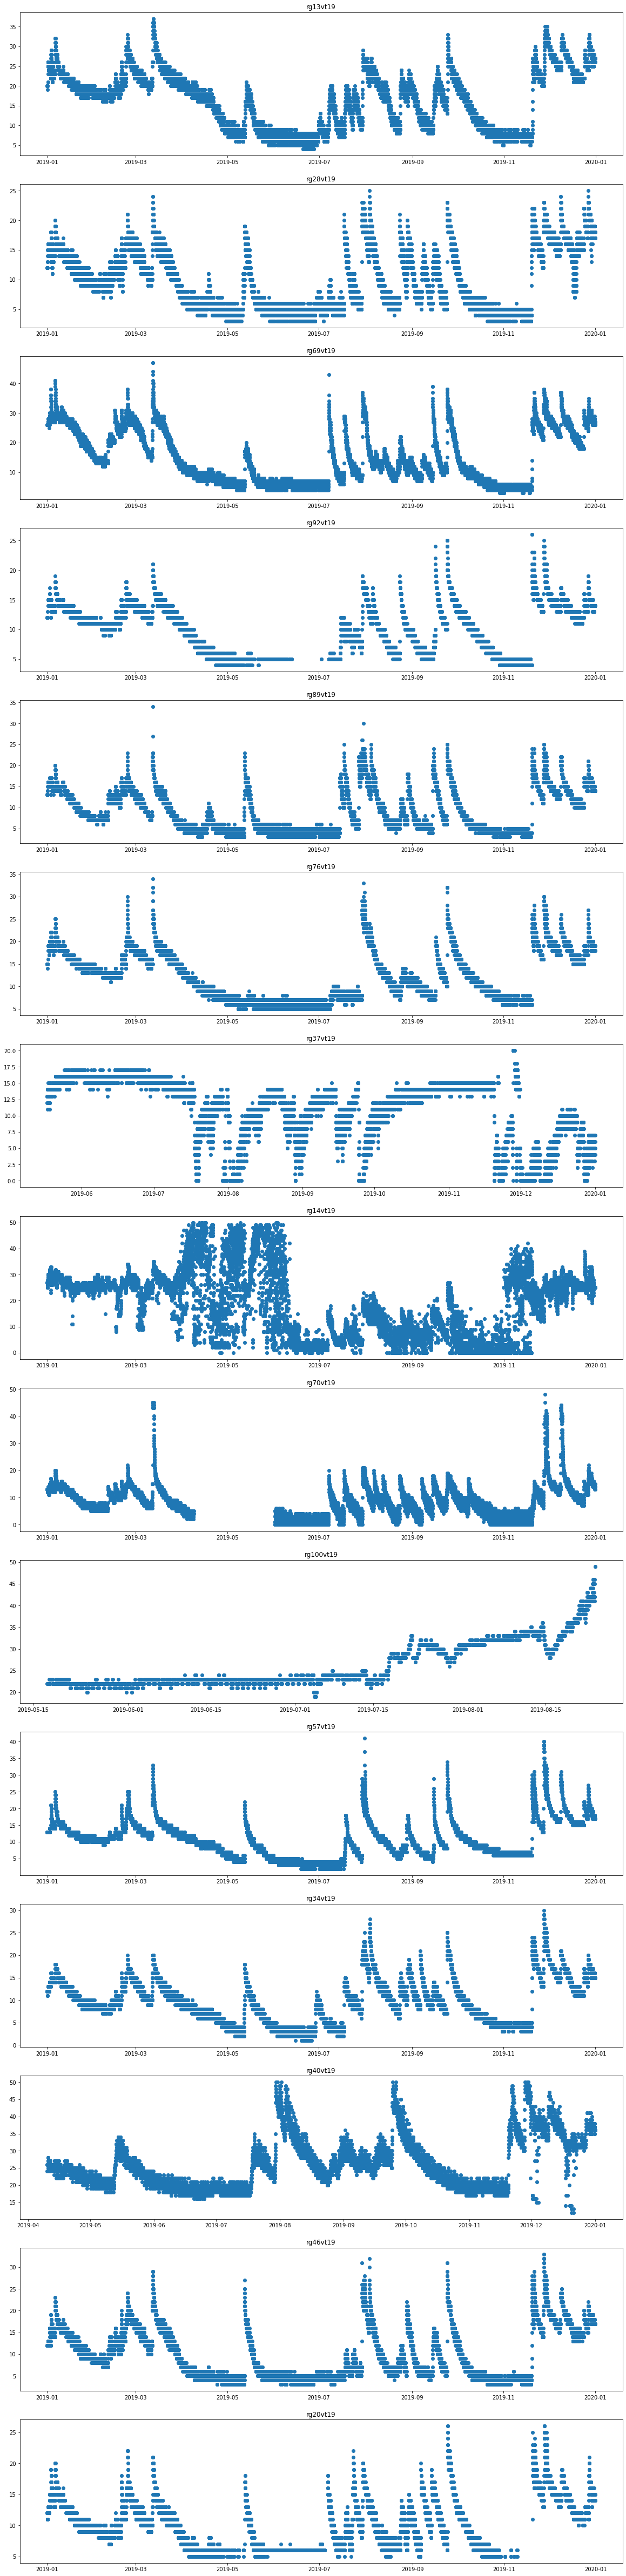

In [13]:
col_nums = 1  
row_nums = math.ceil(len(sensors_df.items()) / col_nums)
plt.figure(figsize=(20, 35))
for i, (k, df) in enumerate(sensors_df.items(), 1):
    df = sensors_df[k]
    plt.subplot(row_nums, col_nums, i)
    plt.scatter(x = df.index, y= df.loc[:,'SM5'])
    plt.title(k)
plt.subplots_adjust(left=None, bottom=None, right=None, top=2 , wspace=None, hspace=None)

### Satellite

In [14]:
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA2/'
BASE_DIR_SCL = './sen2r/out/SCL/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'
BASE_DIR_SAT_IMG_DF = './sat_img_df/' # change name to differenciate from BASE_DIR which means to ./sen2r/dir

boa_files = [f for f in os.listdir(BASE_DIR_BOA,) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

#inSitu_obs_dict = { sensor_name:[] for sensor_name,_ in sensors_coords.items()}

In [15]:
# ----------------------------------PRECALCULATED for speedup

if False :
    print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    boa_dummy  = rs.open(BASE_DIR_BOA + boa_files[0])
    utm_x, utm_y =  get_px_coords_from_raster(boa_dummy,
                                              band = 3, # which band[R|G|B] ? 
                                              no_data = boa_dummy.nodata)
if False :
    haversine_dists = get_distances_pxs_to_sensor(boa_dummy = boa_dummy,
                                                  sensors_coords = sensors_coords,
                                                  utm_x = utm_x,
                                                  utm_y = utm_y)
    print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    
    with open('./haversine_dists.pkl', 'wb') as f:
        pickle.dump(haversine_dists, f)
        
with open('./haversine_dists.pkl', 'rb') as f:
    haversine_dists = pickle.load(f) #TODO: 226 mb will be better use parquet format

In [16]:
# TODO check folder BASE_DIR_SAT_IMG_DF exists if not create
if False : 
    for idx,file in enumerate(boa_files) : 
        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), file))

            boa_fp = BASE_DIR_BOA + file
            raster_date = S2_getDate(boa_fp)
            scl_fp = S2_getSCL(BASE_DIR_SCL, raster_date)
            ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

            boa  = rs.open(boa_fp)
            #scl  = rs.open(scl_fp)
            ndvi  = rs.open(ndvi_fp)

            swir = boa.read(11, masked = True)
            #scl  = scl.read(1, masked = True)
            ndvi = ndvi.read(1)
            ndvi = np.ndarray.flatten(ndvi)
            ndvi = np.delete(ndvi, ndvi == -9999.0)

            swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
            STR  = ((1-swir)**2)/(2*swir)
            STR  = np.ndarray.flatten(STR)
            STR  = np.delete(STR, STR.mask)

            # TODO : check defective_px_perc before proccess the following
            # TODO : add col defective_px {Boolean}  for further filtering
            
            data = {
                'datetime' : S2_get_sensing_dt(boa_fp),
                'ndvi' : ndvi,
                'str'  : STR,
                'utm_x' : utm_x, 
                'utm_y' : utm_y,
                'fpath' : boa_fp
            }
            
            local_df = pd.DataFrame(data)
            local_df.astype({
                'datetime' : 'datetime64[ns]',
                'ndvi' : 'float', 
                'utm_x' : 'float', 
                'utm_y' : 'float',
                'fpath' : 'str'
            })
            local_df = add_scl_col(scl_fp = scl_fp,
                                   ndvi_fp = ndvi_fp,
                                   local_df = local_df,
                                   date = raster_date)            
            local_df.to_parquet(os.path.join(BASE_DIR_SAT_IMG_DF,
                                             datetime.datetime.strftime(raster_date, "%Y-%m-%d")+".parquet"),
                                engine="fastparquet")
                
            print(local_df)
            
        except Exception as e : 
            print("An error occurred while processing data for file %s " % file)
            print("Original message: %s " % e)

In [17]:
ddf = dd.read_parquet(BASE_DIR_SAT_IMG_DF+"*", engine='fastparquet')
print(ddf)

Dask DataFrame Structure:
                      datetime     ndvi      str    utm_x    utm_y   fpath scl_value
npartitions=71                                                                      
                datetime64[ns]  float32  float64  float64  float64  object   float64
                           ...      ...      ...      ...      ...     ...       ...
...                        ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
Dask Name: read-parquet, 71 tasks


_You want the number of processes times the number of threads to equal the number of cores._  
- https://stackoverflow.com/questions/51099685/best-practices-in-setting-number-of-dask-workers

In [18]:
# Ryzen 5 2600: 6 cores 12 threads, 16 GB RAM
client = Client(memory_limit='2.5GB', # per worker
                processes=True,
                n_workers=4,
                threads_per_worker=4)
client

2022-04-04 02:37:46,321 - distributed.diskutils - INFO - Found stale lock file and directory '/home/vyago/Documents/OPTRAM/dask-worker-space/worker-4g7p39qb', purging
2022-04-04 02:37:46,322 - distributed.diskutils - INFO - Found stale lock file and directory '/home/vyago/Documents/OPTRAM/dask-worker-space/worker-oczwcsnm', purging
2022-04-04 02:37:46,322 - distributed.diskutils - INFO - Found stale lock file and directory '/home/vyago/Documents/OPTRAM/dask-worker-space/worker-pqv3b1nj', purging
2022-04-04 02:37:46,323 - distributed.diskutils - INFO - Found stale lock file and directory '/home/vyago/Documents/OPTRAM/dask-worker-space/worker-sh4upuzt', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33985,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 9.31 GiB
Comm: tcp://127.0.0.1:41171,Total threads: 4
Dashboard: http://127.0.0.1:33875/status,Memory: 2.33 GiB
Nanny: tcp://127.0.0.1:34711,


In [17]:
#client.close()

In [19]:
if True : 
    
    meta = pd.DataFrame({
                  'datetime':    pd.Series(dtype='datetime64[ns]'),
                  'ndvi':        pd.Series(dtype='float'),
                  'str':         pd.Series(dtype='float'),
                  'utm_x':       pd.Series(dtype='float'),
                  'utm_y':       pd.Series(dtype='float'),
                  'fpath':       pd.Series(dtype='str'),
                  'scl_value':    pd.Series(dtype='int'),
                  'dist':        pd.Series(dtype='float'),
                  'sensor_name': pd.Series(dtype='str'),
                  'SM5':         pd.Series(dtype='float') # ??? can be cast to float or float32 ? 
    })
    
    meta.set_index("datetime", inplace=True)

    inSitu_obs_dfs_list = list()
    for sensor_name, sensor_coords in sensors_coords.items() :
        now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        print('[%s] : processing sensor %s... \n' % (now, sensor_name))
        try : 

            inSitu_obs_df = ddf.map_partitions(build_inSitu_obs, 
                                               dest_lat_lng  = sensors_coords[sensor_name],
                                               sensor_df     = sensors_df[sensor_name],
                                               dists         = haversine_dists[sensor_name],
                                               sensor_name   = sensor_name,
                                               meta =  meta)

            inSitu_obs_dfs_list.append(inSitu_obs_df)
#            del inSitu_obs_df
        except Exception as e : 
            print("An error occurred while processing data for sensor %s " % sensor_name)
            print("Original message: %s " % e)

[2022/04/04 02:37:50] : processing sensor rg13vt19... 

[2022/04/04 02:37:56] : processing sensor rg14vt19... 

[2022/04/04 02:38:02] : processing sensor rg20vt19... 

[2022/04/04 02:38:08] : processing sensor rg28vt19... 

[2022/04/04 02:38:14] : processing sensor rg34vt19... 

[2022/04/04 02:38:21] : processing sensor rg37vt19... 



2022-04-04 02:38:26,338 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:38:26,628 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:38:26,953 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:38:27,293 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2022/04/04 02:38:27] : processing sensor rg40vt19... 



2022-04-04 02:38:32,323 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-04 02:38:32,609 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-04 02:38:32,909 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-04 02:38:33,232 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:38:33,558 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:38:33,911 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:34,265 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2022/04/04 02:38:34] : processing sensor rg46vt19... 



2022-04-04 02:38:39,191 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2022-04-04 02:38:39,515 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:39,826 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:40,168 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:40,534 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:40,888 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2022/04/04 02:38:41] : processing sensor rg57vt19... 



2022-04-04 02:38:45,946 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:46,269 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:46,622 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:46,974 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


[2022/04/04 02:38:47] : processing sensor rg69vt19... 



2022-04-04 02:38:51,998 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:38:52,326 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:38:52,673 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:38:53,014 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:38:53,388 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:38:53,792 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[2022/04/04 02:38:53] : processing sensor rg70vt19... 



2022-04-04 02:38:58,939 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:38:59,274 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:38:59,660 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-04-04 02:39:00,039 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


[2022/04/04 02:39:00] : processing sensor rg76vt19... 



2022-04-04 02:39:05,167 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:39:05,512 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:39:05,861 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:39:06,202 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-04-04 02:39:06,560 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-04-04 02:39:06,959 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


[2022/04/04 02:39:07] : processing sensor rg82vt19... 

An error occurred while processing data for sensor rg82vt19 
Original message: 'rg82vt19' 
[2022/04/04 02:39:07] : processing sensor rg83vt19... 

An error occurred while processing data for sensor rg83vt19 
Original message: 'rg83vt19' 
[2022/04/04 02:39:07] : processing sensor rg89vt19... 



2022-04-04 02:39:12,174 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:39:12,542 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-04-04 02:39:12,960 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:13,391 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2022/04/04 02:39:13] : processing sensor rg92vt19... 



2022-04-04 02:39:18,697 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:19,062 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:19,473 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:19,850 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:20,228 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:20,632 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2022/04/04 02:39:20] : processing sensor rg100vt19... 



2022-04-04 02:39:25,665 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-04-04 02:39:26,072 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:39:26,464 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:39:26,874 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


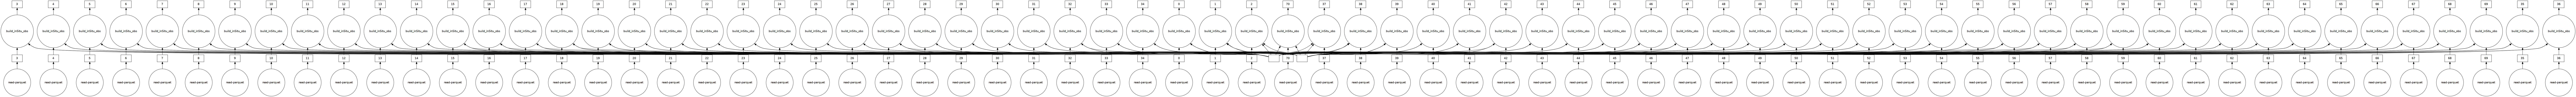

In [20]:
inSitu_obs_dfs_list[0].visualize()

In [21]:
len(inSitu_obs_dfs_list)

15

2022-04-04 02:40:39,680 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


In [ ]:
inSitu_dfs_0 = inSitu_obs_dfs_list[0].compute()
inSitu_dfs_1 = inSitu_obs_dfs_list[1].compute()
inSitu_dfs_2 = inSitu_obs_dfs_list[2].compute()
inSitu_dfs_3 = inSitu_obs_dfs_list[3].compute()
inSitu_dfs_4 = inSitu_obs_dfs_list[4].compute()

inSitu_dfs_5 = inSitu_obs_dfs_list[5].compute()
inSitu_dfs_6 = inSitu_obs_dfs_list[6].compute()
inSitu_dfs_7 = inSitu_obs_dfs_list[7].compute()
inSitu_dfs_8 = inSitu_obs_dfs_list[8].compute()
inSitu_dfs_9 = inSitu_obs_dfs_list[9].compute()

inSitu_dfs_10 = inSitu_obs_dfs_list[10].compute()
inSitu_dfs_11 = inSitu_obs_dfs_list[11].compute()
inSitu_dfs_12 = inSitu_obs_dfs_list[12].compute()
inSitu_dfs_13 = inSitu_obs_dfs_list[13].compute()
inSitu_dfs_14 = inSitu_obs_dfs_list[14].compute()

2022-04-04 02:41:24,079 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:24,714 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:25,495 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:26,281 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:27,121 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:28,043 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:29,087 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-04-04 02:41:30,243 - distributed.utils_perf - WARNING - full garbage collections took

This way do not work:

In [ ]:
inSitu_dfs = dask.compute(*inSitu_obs_dfs_list)
inSitu_global = pd.concat(inSitu_dfs)

2022-04-04 02:25:31,682 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:32,525 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:33,382 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:34,345 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:35,393 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:36,554 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:37,859 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-04-04 02:25:39,316 - distributed.utils_perf - WARNING - full garbage collections took

In [ ]:

with open('./inSitu_dfs.pkl', 'wb') as f:
    pickle.dump(inSitu_dfs, f)   

In [ ]:
#client.close()

#with open('./inSitu_dfs.pkl', 'rb') as f:
#    inSitu_dfs = pickle.load(f)
#inSitu_dfs_global = pd.concat(inSitu_dfs)

In [ ]:
inSitu_obs_dfs_list[0].visualize()

In [ ]:
inSitu_df_1 = inSitu_obs_dfs_list[0].compute()

In [ ]:
inSitu_dfs

In [ ]:
df_global = ddf[["str", "ndvi", "scl_value"]].compute()
df_global

In [ ]:
del df_global

In [ ]:
mask = (ddf["scl_value"] == 4) | (ddf["scl_value"] == 5)

In [ ]:
df_global = ddf.loc[mask,["ndvi", "str"]].compute()

In [ ]:
#df = pd.DataFrame(data=X, columns=["x", "y"])  # create a DF from array
cvs = ds.Canvas(plot_width=800, plot_height=500)  # auto range or provide the `bounds` argument

plt.figure(figsize=(20, 35))
#agg = cvs.points(df, 'x', 'y')  # this is the histogram
agg = cvs.points(df_global, 'ndvi', 'str')  # this is the histogram
img = ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black").to_pil()  # create a rasterized image
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))

plt.scatter(x = df_global.loc[:,'ndvi'], y = df_global.loc[:,'str'], label = "global", alpha = 0.1)
plt.scatter(x = inSitu_dfs_global.loc[:,'ndvi'], y = inSitu_dfs_global.loc[:,'str'], label = 'inSitu')
plt.legend()
plt.show()

# OPTRAM FIT

In [ ]:
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STRd_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi) 

def STRw_f(intercept, slope, ndvi):
    return (intercept + slope*ndvi)

In [ ]:
edge_dry_intercept = -0.2
edge_dry_slope = 2.3

edge_wet_intercept = 1.8 
edge_wet_slope = 4

plt.figure(figsize=(15, 7))
plt.scatter(df_global.loc[:,'ndvi'], df_global.loc[:,'str'])
plt.scatter(inSitu_dfs_global.loc[:,'ndvi'], inSitu_dfs_global.loc[:,'str'], label = 'inSitu', alpha = 0.1)
plt.axline((0, edge_dry_intercept), slope=edge_dry_slope, color='red', label='dry')
plt.axline((0, edge_wet_intercept), slope=edge_wet_slope, color='blue', label='edge')
plt.legend()
plt.show()

In [ ]:
str_d =  STRd_f(intercept = edge_dry_intercept,
                slope = edge_dry_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

str_w =  STRd_f(intercept = edge_wet_intercept,
                slope = edge_wet_slope,
                ndvi  = inSitu_df.loc[:,'ndvi'])

inSitu_df["W"] = W(STRd = str_d, STRw = str_w, STR = inSitu_df.loc[:,'str'])
inSitu_df["W_alt"] = (edge_dry_intercept + edge_dry_slope*inSitu_df.loc[:,'ndvi'] - inSitu_df.loc[:,'str'])/(edge_dry_intercept - edge_wet_intercept +(edge_dry_slope - edge_wet_slope)*inSitu_df.loc[:,'ndvi'])

plt.scatter(inSitu_df.loc[:,'SM5'], inSitu_df.loc[:,'W'])

# BASURA

In [ ]:
# https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python
fname = "./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
from shapely.geometry import Point

dataset = boa
val = ndvi
no_data = dataset.nodata
geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
df.crs = dataset.crs
geometry

In [ ]:
print(geometry[0].xy[0])

In [ ]:
boa.read(8, masked = True)

### NDVI band vs BOA computed ndvi

In [ ]:
import rasterio as rs

# NDVI 
ndvi_fp = './sen2r/indices/NDVI/S2A2A_20190415_041_Walnut-Gulch_NDVI_10.tif'
raster = rs.open(ndvi_fp)
print(raster.meta)

In [ ]:
raster_ndvi = raster.read(1)
raster_ndvi = np.ndarray.flatten(raster_ndvi)
raster_ndvi = np.delete(raster_ndvi, raster.mask)
print(raster_ndvi)

plt.hist(raster_ndvi, bins = 100)
plt.show()

In [ ]:
#STR
BASE_DIR = './sen2r/out/'
BASE_DIR_BOA = './sen2r/out/BOA_2/'
boa_fp = "./sen2r/out/BOA_2/S2A2A_20190415_041_Walnut-Gulch_BOA_10.tif"
raster_date = S2_getDate(boa_fp)
#scl_fp = S2_getSCL(BASE_DIR, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
r    = boa.read(3, masked = True)
nir  = boa.read(8, masked = True)
swir = boa.read(11, masked = True)
swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
#ndvi = (nir - r)/(nir + r)
STR  = ((1-swir)**2)/(2*swir)
scl  = scl.read(1, masked = True)
print(boa.meta)
STR

In [ ]:
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

plt.hist(STR, bins = 100)
plt.show()

In [ ]:
STR

In [ ]:
plt.scatter(raster_ndvi, STR)
plt.show()

In [ ]:
print(len(raster_ndvi))
print(len(STR))

print(len(raster_ndvi) == len(STR))

## Resampling  SCL 60mt/px to 10mt/px

### Using gdal

https://gis.stackexchange.com/questions/234022/resampling-a-raster-from-python-without-using-gdalwar

In [ ]:
from osgeo import gdal, gdalconst


BASE_DIR_BOA  = './sen2r/out/BOA2/'
BASE_DIR_NDVI = './sen2r/indices/NDVI/'
BASE_DIR_SCL  = './sen2r/out/SCL/'


boa_files = [f for f in os.listdir(BASE_DIR_BOA) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]
boa_fp = BASE_DIR_BOA + boa_files[0]
raster_date = S2_getDate(boa_fp)
print(raster_date)
scl_fp = S2_getSCL(BASE_DIR_SCL, raster_date)
print(scl_fp)
ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)
print(ndvi_fp)

In [ ]:
def get_px_coords_from_raster(boa, no_data, band) :
    print('[%s] : Retrieving px location coords...' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    dataset = boa
    val = boa.read(band, masked = True)
    #no_data = dataset.nodata
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    coords_utm = [(point.x, point.y)  for point in geometry]
    print('[%s] : Done\n' % datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
    return (zip(*coords_utm))

def resample_raster_gdal_nn(input_file, ref_file, out_file):

    # Opening input
    input = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = input.GetProjection()
    inputTrans = input.GetGeoTransform()

    # Opening ref
    reference = gdal.Open(ref_file, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    # Resampling
    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(out_file,x,y,1,bandreference.DataType)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_NearestNeighbour)
    del output

In [ ]:
input_file = scl_fp
ref_file = ndvi_fp
#tempfile ?
out_file = "./SCL_resampled_10_gdal_" + raster_date.strftime("%Y-%m-%d") + ".tif"

resample_raster_gdal_nn(input_file, ref_file, out_file)

scl_10_dataset  = rs.open(out_file)
scl_10          = scl_10_dataset.read(1, masked = True)
scl_10_flatten  = np.ndarray.flatten(scl_10) 


x,y = get_px_coords_from_raster(scl_10_dataset,
                                no_data = 0,
                                band = 1) 

scl_10_df = pd.DataFrame({
    'utm_x' : x,
    'utm_y' : y,
    'scl_value' : np.delete(scl_10_flatten, scl_10_flatten == 0)
})
scl_10_df = scl_10_df.astype('int32')
scl_10_df

simulating creation of local_df datarame on boa_files outer iteration

In [ ]:
boa_dummy = rs.open(boa_fp)
utm_x, utm_y =  get_px_coords_from_raster(boa_dummy, 
                                          no_data = boa_dummy.nodata,
                                          band = 3)
#boa_fp = BASE_DIR_BOA + file
print(boa_fp)
raster_date = S2_getDate(boa_fp)
scl_fp = S2_getSCL(BASE_DIR_BOA, raster_date)
ndvi_fp = S2_getNDVI(BASE_DIR_NDVI, raster_date)

boa  = rs.open(boa_fp)
scl  = rs.open(scl_fp)
ndvi  = rs.open(ndvi_fp)

swir = boa.read(11, masked = True)
scl  = scl.read(1, masked = True)
ndvi = ndvi.read(1)
ndvi = np.ndarray.flatten(ndvi)
ndvi = np.delete(ndvi, ndvi == -9999.0)

swir = swir / 10000 #  #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
STR  = ((1-swir)**2)/(2*swir)
STR  = np.ndarray.flatten(STR)
STR  = np.delete(STR, STR.mask)

# TODO : check defective_px_perc before proccess the following
# TODO : add col defective_px {Boolean}  for further filtering

data = {
        'datetime' : S2_get_sensing_dt(boa_fp),
        'ndvi' : ndvi,
        'str'  : STR,
#        'defective_px_perc' : S2_defective_px_perc(np.ndarray.flatten(scl.data)),
        'utm_x' : utm_x, 
        'utm_y' : utm_y,
        'fpath' : boa_fp
}
local_df = pd.DataFrame(data)

In [ ]:
print(len(local_df), local_df.columns)
print(len(scl_10_df), scl_10_df.columns)

In [ ]:
local_df_merged = pd.merge(local_df, scl_10_df, on = ["utm_x", "utm_y"], how = "left")
local_df_merged

In [ ]:
np.unique(local_df_merged["scl_value"], return_counts=True)

In [ ]:
local_df_merged["scl_value"].isna().sum()

In [ ]:
print(len(local_df))
print(len(local_df_merged)) # should have less rows than previous